In [189]:
___Author___='LumberJack Jyss'

In [190]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


In [375]:
print('Importing librairies...')
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,roc_curve,confusion_matrix,classification_report
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dense
from keras.utils import to_categorical
%matplotlib inline
print('Librairies imported')

Importing librairies...
Librairies imported


In [376]:
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")
tf.logging.set_verbosity(tf.logging.ERROR)

In [435]:
df_15min = pd.read_csv('20190526 data prepared.csv')
df_15min = df_15min.iloc[:,1:]
df_15min = df_15min.dropna()
df_15min.reset_index(inplace=True,drop=True)

In [436]:
df_15min.isnull().sum().sum()

0

In [437]:
df_15min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6441 entries, 0 to 6440
Data columns (total 27 columns):
Date                  6441 non-null object
Vix                   6441 non-null float64
Varop_Spy             6441 non-null float64
Varhl_spy             6441 non-null float64
Varop_vix             6441 non-null float64
Varhl_vix             6441 non-null float64
RSI                   6441 non-null float64
75 - RSI              6441 non-null float64
RSI - 25              6441 non-null float64
BBD_Delta_Up          6441 non-null float64
delta5_8              6441 non-null float64
delta8_10             6441 non-null float64
delta10_12            6441 non-null float64
delta12_15            6441 non-null float64
delta15_30            6441 non-null float64
delta30_35            6441 non-null float64
delta35_40            6441 non-null float64
delta40_45            6441 non-null float64
delta45_50            6441 non-null float64
Spread                6441 non-null float64
Peaks         

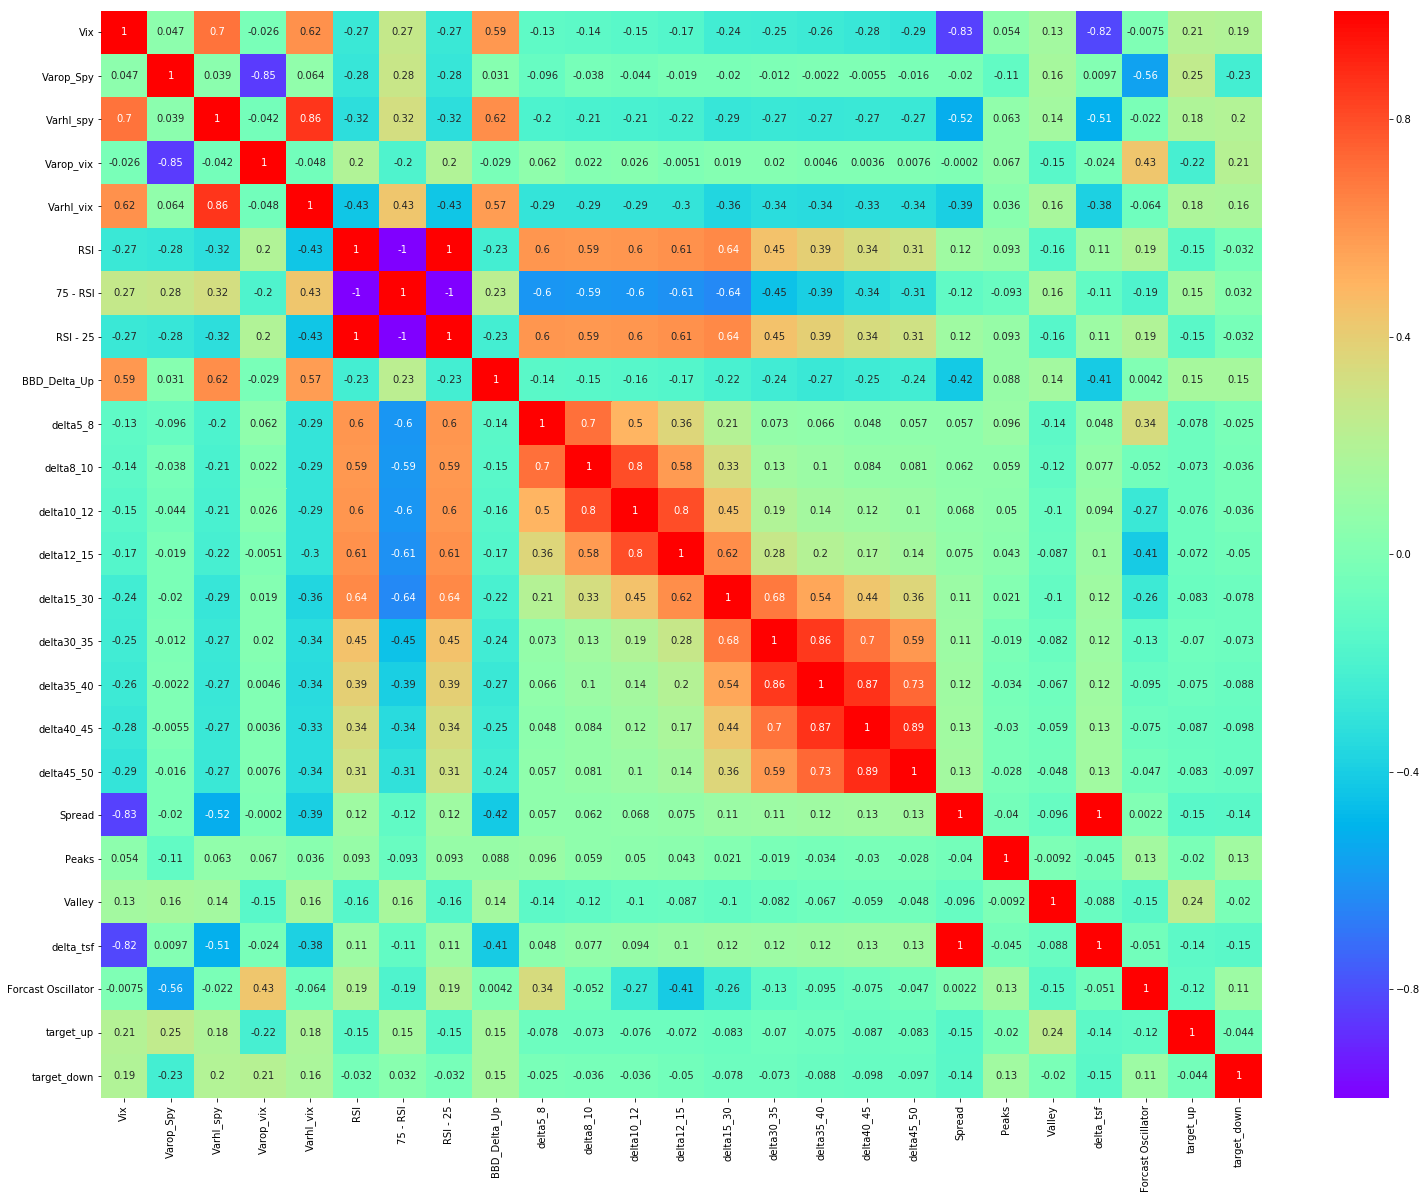

In [438]:
plt.figure(figsize=(26,20))
sns.heatmap(df_15min.iloc[:,:-1].corr(),annot=True,cmap='rainbow')
plt.show()

In [439]:
df_15min.shape

(6441, 27)

In [440]:
df_15min['target_up'].sum(),df_15min['target_down'].sum()

(278, 263)

In [459]:
delta = round(df_15min.shape[0])
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("# of periods : ",delta)
print('On 80% - 20% slash : ')
print('Bloc 1 : ',bloc1,' periods (',df_15min.iloc[bloc1,0],')\nBloc 2 :',bloc2,' periods (',df_15min.iloc[bloc2,0],')')
print('First period :',df_15min.iloc[0,0])
print('Last period :',df_15min.iloc[df_15min.shape[0]-1,0])


# of periods :  6441
On 80% - 20% slash : 
Bloc 1 :  5153  periods ( 20190321  17:30:00 )
Bloc 2 : 1288  periods ( 20180814  21:15:00 )
First period : 20180604  21:15:00
Last period : 20190531  21:45:00


In [460]:
X = df_15min.iloc[:,1:-4]
#X = X.drop(['Peaks','Valley'],axis=1)
#X = X.drop(['75 - RSI','RSI - 25'],axis=1)
y_up = df_15min.iloc[:,-3].values
y_down = df_15min.iloc[:,-2].values


In [461]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6441 entries, 0 to 6440
Data columns (total 22 columns):
Vix             6441 non-null float64
Varop_Spy       6441 non-null float64
Varhl_spy       6441 non-null float64
Varop_vix       6441 non-null float64
Varhl_vix       6441 non-null float64
RSI             6441 non-null float64
75 - RSI        6441 non-null float64
RSI - 25        6441 non-null float64
BBD_Delta_Up    6441 non-null float64
delta5_8        6441 non-null float64
delta8_10       6441 non-null float64
delta10_12      6441 non-null float64
delta12_15      6441 non-null float64
delta15_30      6441 non-null float64
delta30_35      6441 non-null float64
delta35_40      6441 non-null float64
delta40_45      6441 non-null float64
delta45_50      6441 non-null float64
Spread          6441 non-null float64
Peaks           6441 non-null int64
Valley          6441 non-null int64
delta_tsf       6441 non-null float64
dtypes: float64(20), int64(2)
memory usage: 1.1 MB


In [462]:
X.iloc[:5,[6,7]]

,75 - RSI,RSI - 25
0,13.172975,36.827025
1,11.884473,38.115527
2,14.439686,35.560314
3,9.898487,40.101513
4,8.200796,41.799204


In [463]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
#y_up = scaler.fit_transform(np.array(y_up).reshape(-1,1))
#y_down = scaler.fit_transform(np.array(y_down).reshape(-1,1))
y_up = np.array(y_up).reshape(-1,1)
y_down = np.array(y_down).reshape(-1,1)

In [464]:
X[:5,[6,7]]

array([[0.37161507, 0.62838493],
       [0.35493494, 0.64506506],
       [0.38801312, 0.61198688],
       [0.32922562, 0.67077438],
       [0.30724839, 0.69275161]])

In [465]:
Xtrain = X[:bloc1,:]
Xtest = X[bloc1:,:]
ytrain_up = y_up[:bloc1,:]
ytest_up = y_up[bloc1:,:]
ytrain_down = y_down[:bloc1,:]
ytest_down = y_down[bloc1:,:]

In [466]:
Xtrain.shape,ytrain_up.shape,ytrain_down.shape,ytest_down.shape,ytest_up.shape

((5153, 22), (5153, 1), (5153, 1), (1288, 1), (1288, 1))

In [467]:

Xtrain.shape

(5153, 22)

In [468]:
from keras.layers import Bidirectional
n_steps = Xtrain.shape[0]
n_features = Xtrain.shape[1]
Xtrain = Xtrain.reshape((Xtrain.shape[0],1,Xtrain.shape[1]))
Xtest = Xtest.reshape((Xtest.shape[0],1,Xtest.shape[1]))
ytrain_up = ytrain_up.reshape((ytrain_up.shape[0],1,ytrain_up.shape[1]))
ytrain_down = ytrain_down.reshape((ytrain_down.shape[0],1,ytrain_down.shape[1]))
ytest_up = ytest_up.reshape((ytest_up.shape[0],1,ytest_up.shape[1]))
ytest_down = ytest_down.reshape((ytest_down.shape[0],1,ytest_down.shape[1]))

In [469]:
Xtrain.shape,ytrain_up.shape,ytrain_down.shape,ytest_down.shape,ytest_up.shape

((5153, 1, 22), (5153, 1, 1), (5153, 1, 1), (1288, 1, 1), (1288, 1, 1))

In [488]:
print('Processing move_up')
model_up = Sequential()
model_up.add(Bidirectional(LSTM(50, input_shape=(Xtrain.shape[0], Xtrain.shape[1]),return_sequences=True,dropout=0.2, recurrent_dropout=0.2,activation='relu')))
model_up.add(Bidirectional(LSTM(50, input_shape=(Xtrain.shape[0], Xtrain.shape[1]),return_sequences=True,dropout=0.2, recurrent_dropout=0.2,activation='relu')))
model_up.add(TimeDistributed(Dense(1, activation='sigmoid')))
model_up.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_up.fit(Xtrain, ytrain_up, epochs=50, batch_size=32, verbose=0)
print('PRocessing move_down')
model_down = Sequential()
model_down.add(Bidirectional(LSTM(50, input_shape=(Xtrain.shape[0], Xtrain.shape[1]),return_sequences=True,dropout=0.2, recurrent_dropout=0.2,activation='relu')))
model_down.add(Bidirectional(LSTM(50, input_shape=(Xtrain.shape[0], Xtrain.shape[1]),return_sequences=True,dropout=0.2, recurrent_dropout=0.2,activation='relu')))
model_down.add(TimeDistributed(Dense(1, activation='sigmoid')))
model_down.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_down.fit(Xtrain, ytrain_down, epochs=50, batch_size=32, verbose=0)
print('Done')

Processing move_up
PRocessing move_down
Done


In [489]:
yhat_up = model_up.predict_classes(Xtest)
yhat_down = model_down.predict_classes(Xtest)

In [490]:
train_acc_up = model_up.evaluate(Xtrain, ytrain_up,verbose=1)
train_acc_down = model_down.evaluate(Xtrain, ytrain_down,verbose=1)
train_acc_up,train_acc_down

5153/5153 [==============================] - 4s 820us/step


([0.14781627384774054, 0.9575004851542791],
 [0.138443036525415, 0.9578886085775277])

In [495]:
score_up = model_up.evaluate(Xtest, ytest_up,verbose=1)
score_down = model_down.evaluate(Xtest, ytest_down,verbose=1)
score_up,score_down

ValueError: Error when checking target: expected time_distributed_36 to have 3 dimensions, but got array with shape (1288, 1)

In [496]:
yhat_up = yhat_up.reshape(len(yhat_up),)
yhat_down = yhat_down.reshape(len(yhat_down),)
ytest_up = ytest_up.reshape(len(ytest_up),)
ytest_down = ytest_down.reshape(len(ytest_down),)

In [497]:
confusion_matrix(ytest_up, yhat_up),

(array([[1246,    0],
        [  42,    0]]),)

In [498]:
confusion_matrix(ytest_down, yhat_down)

array([[1243,    0],
       [  45,    0]])

In [499]:

accuracy_up = accuracy_score(ytest_up, yhat_up)
accuracy_down = accuracy_score(ytest_down, yhat_down)

# La précision permet de mesurer la capacité du modèle à refuser résultats non-pertinents : vrais_positifs/(vrais_positifs+faux_positifs)
precision_up = precision_score(ytest_up, yhat_up)  
precision_down = precision_score(ytest_down, yhat_down) 


# Recall : (vrai_positifs/(vrais_positifs+faux_négatifs))
recall_up = recall_score(ytest_up, yhat_up) 
recall_down = recall_score(ytest_down, yhat_down) 


roc_up=roc_auc_score(ytest_up,yhat_up)
roc_down=roc_auc_score(ytest_down,yhat_down)

In [500]:
print('RESULTATS UP\n')
print('Accuracy: %.2f%%' % (accuracy_up * 100.0))
print("Precision: %.2f%% " % (precision_up *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_up * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("AUC: %.2f%% " % (roc_up *100))
# get probabilities for positive class

print(classification_report(ytest_up, yhat_up))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_up, yhat_up))
print('Matrice de confusion :')
conf_matrix

RESULTATS UP

Accuracy: 96.74%
Precision: 0.00%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 0.00%   => Positifs trouvés par Golem sur tous les positifs existants
AUC: 50.00% 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1246
           1       0.00      0.00      0.00        42

   micro avg       0.97      0.97      0.97      1288
   macro avg       0.48      0.50      0.49      1288
weighted avg       0.94      0.97      0.95      1288

[[1246    0]
 [  42    0]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


In [501]:
print('RESULTATS DOWN\n')
print('Accuracy: %.2f%%' % (accuracy_down * 100.0))
print("Precision: %.2f%% " % (precision_down *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_down * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("AUC: %.2f%% " % (roc_down *100))
# get probabilities for positive class

print(classification_report(ytest_down, yhat_down))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_down, yhat_down))
print('Matrice de confusion :')
conf_matrix

RESULTATS DOWN

Accuracy: 96.51%
Precision: 0.00%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 0.00%   => Positifs trouvés par Golem sur tous les positifs existants
AUC: 50.00% 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1243
           1       0.00      0.00      0.00        45

   micro avg       0.97      0.97      0.97      1288
   macro avg       0.48      0.50      0.49      1288
weighted avg       0.93      0.97      0.95      1288

[[1243    0]
 [  45    0]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


In [502]:
len(df_15min)-(len(df_15min)-241)

241

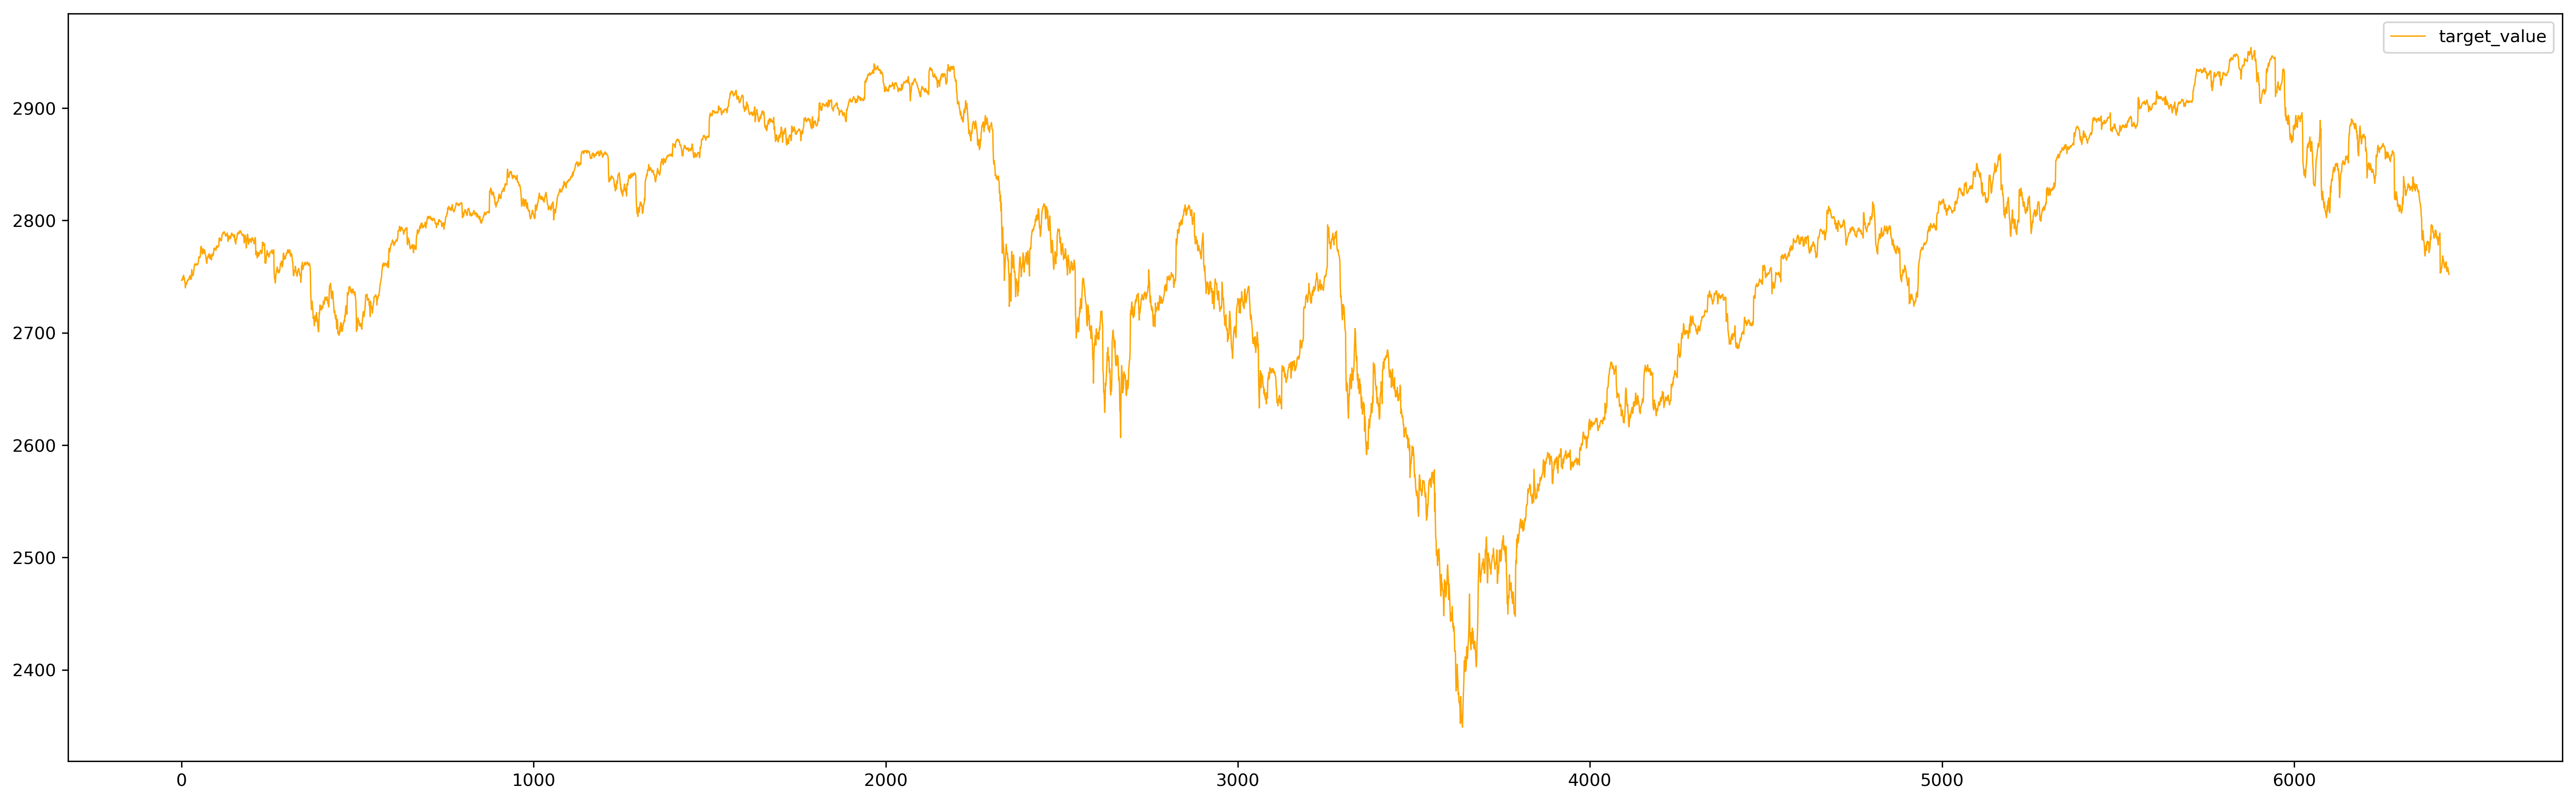

In [503]:
plt.figure(figsize=(26,8),dpi=300)
plt.plot(df_15min['target_value'],color='orange',lw=0.8)
a = -1
for i in range(len(df_15min)-241,len(df_15min)):
    a+=1
    if yhat_up[a] == 1:
        plt.scatter(x=df_15min.index[i],y=df_15min.iloc[i,-1],c='g',marker='o')
    elif yhat_down[a] == 1:
        plt.scatter(x=df_15min.index[i],y=df_15min.iloc[i,-1],c='r',marker='o')
plt.legend()

In [504]:
sum(yhat_up),sum(yhat_down)

(0, 0)

In [ ]:
# save the model to disk
filename = 'finalized_model_long.sav'
pickle.dump(model_up, open(filename, 'wb'))
filename = 'finalized_model_short.sav'
pickle.dump(model_down, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)